# Lab 2
## KN-414 Danylo Melnyk
Вибрати з інтернету набори зображень з різною контрастністю і різним флуктуаціями
освітленості. Для кожного зображення побудувати варіант спотвореного (видозміненого
зображення). Для кожної отриманої пари побудувати дескриптор і проаналізувати
можливість суміщення цих зображень і з визначення параметрів геметричних перетворень
(кут повороту, зміщень в напрямку х і напрямку y).

9. LDB

Для перевірки збігів необхідно написати власну функцію матчінгу, а результати її роботи
перевірити засобами OpenCV. Якщо повної реалізації дескриптора не має в OpenCV, то
такий необхідно створити власну функцію побудови цих дискрипторів. У цьому випадку
матчінг можна здійснювати стандартними засобами (якщо це можливо).
Додаткове завдання (оцінюється у додаткові бали) - в процесі порівняння дескрипторів
використати власну реалізацію алгоритму RANSAC.
Додаткові бали також надаються за написання власної функції побудови дексрипторів, без
використання OpenCV

In [1]:
import cv2
import numpy as np
from scipy.spatial.distance import hamming

from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def show_imgs(imgs, labels):
    if isinstance(imgs, list):
        fig, axs = plt.subplots(nrows=1, ncols=len(imgs), figsize=(8, 8 * len(imgs)))

        for ax, img, label in zip(axs, imgs, labels):
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(label)
            ax.axis('off')
    else:
        plt.imshow(cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB))
        plt.title(labels)
        plt.axis('off')

    plt.show()

In [3]:
def get_random_crop(image, crop_height, crop_width):
    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop

In [6]:
paths = [
    "imgs/23733.jpg", "imgs/23776.jpg",
    "imgs/24063.jpg", "imgs/24317.jpg",
    "imgs/212609.jpg",
    "imgs/HighRes.jpg", "imgs/LowRes.png", "imgs/LowContrast.png"
]

imgs = [cv2.imread(path) for path in paths]
imgs_ = []
for img in imgs:
    h, w, _ = img.shape

    imgs_.append(get_random_crop(img, max(100, int(h * 0.4)), max(100, int(h * 0.4))))

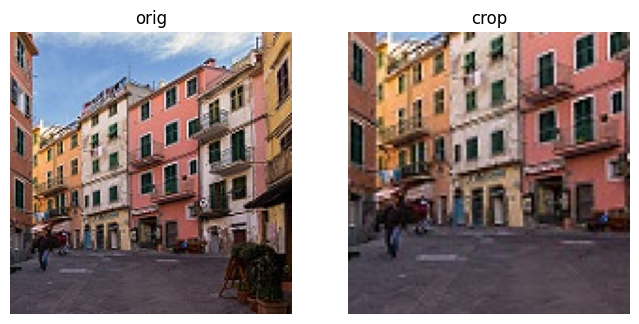

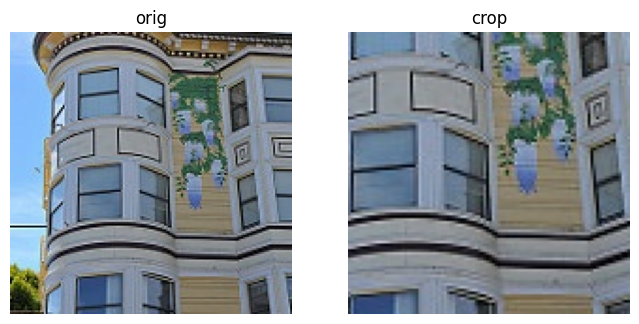

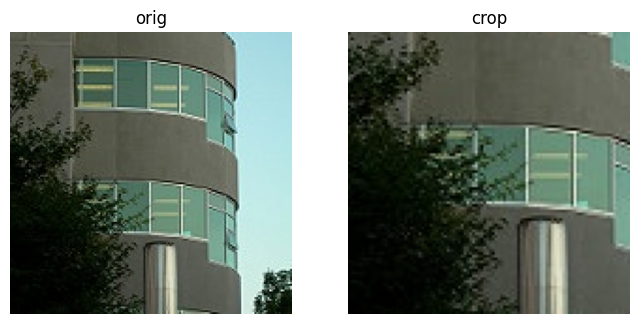

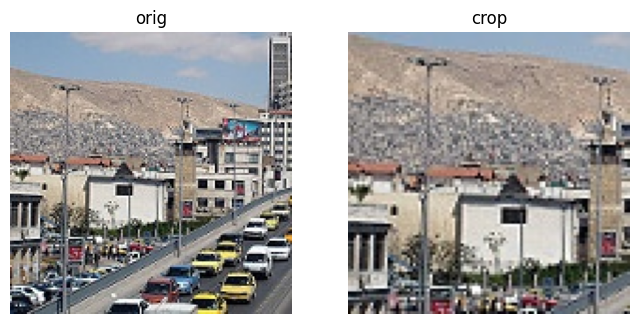

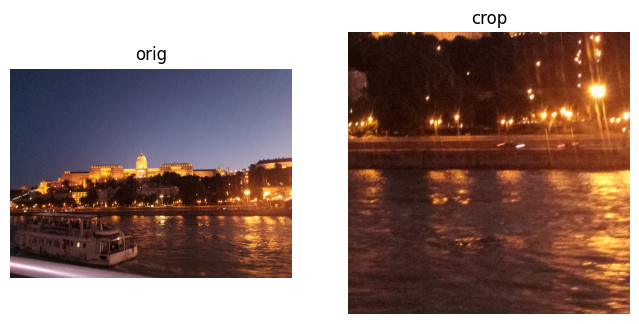

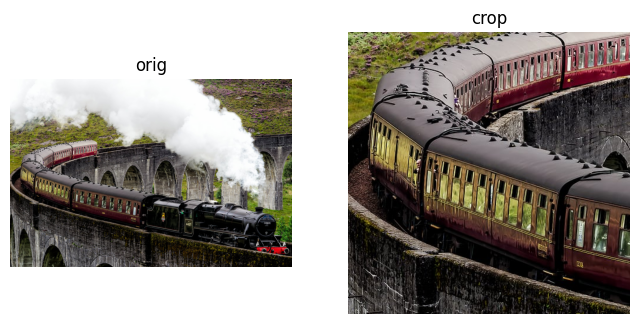

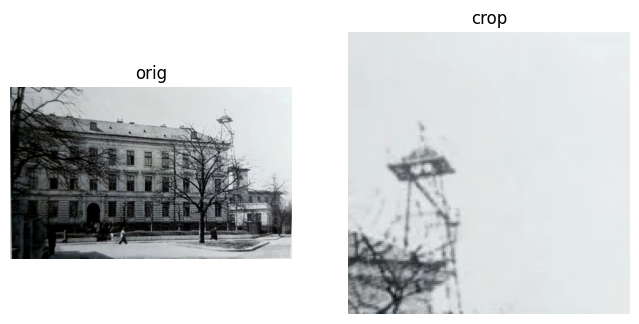

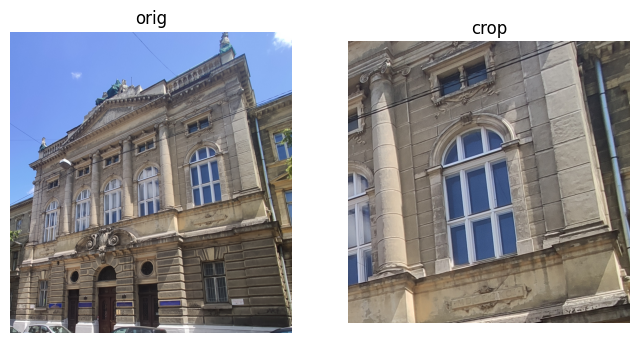

In [7]:
for img, img_ in zip(imgs, imgs_):
    show_imgs([img, img_], ["orig", "crop"])

In [8]:
indexes = np.random.RandomState(123).choice(486, 256, replace=False)
# indexes = np.random.RandomState(123).choice(3276, 256, replace=False) #[2, 3, 4, 5, 6]

In [9]:
def match(descriptors_0, descriptors_1):
    matchings = []
    for i1, d1 in enumerate(descriptors_0):
        distances = []
        for i2, d2 in enumerate(descriptors_1):
            distances.append(hamming(d1, d2))

        i2_min = np.argmin(distances)
        matchings.append(cv2.DMatch(_distance=distances[i2_min], _imgIdx=0, _queryIdx=i1, _trainIdx=i2_min))

    return matchings

In [10]:
def get_grid_mean(patch, grid_shape):
    """
    patch 45 x 45


    [
        [patch[:22, :22], patch[22:, :22]],
        [patch[:22, 22:], patch[22:, 22:]]
    ]
    [
        [patch[:15, :15], patch[15:30, :15], patch[30:, :15]],
        [patch[:15, 15:30], patch[15:30, 15:30], patch[30:, 15:30]],
        [patch[:15, 30:], patch[15:30, 30:], patch[30:, 30:]]
    ]

    [
        [patch[:11, :11], patch[11:22, :11], patch[22:33, :11], patch[33:, :11]],
        [patch[:11, 11:22], patch[11:22, 11:22], patch[22:33, 11:22], patch[33:, 11:22]],
        [patch[:11, 22:33], patch[11:22, 22:33], patch[22:33, 22:33], patch[33:, 22:33]],
        [patch[:11, 33:], patch[11:22, 33:], patch[22:33, 33:], patch[33:, 33:]],
    ]
    """
    # 45 x 45

    s = patch.shape[0] // grid_shape
    res = np.zeros(grid_shape * grid_shape)

    for row in range(grid_shape):
        for col in range(grid_shape):
            res[row * grid_shape + col] = np.mean(patch[col * s: (col + 1) * s, row * s:(row + 1) * s])

    return res


def ldb_descriptors(img, key_points, patch_size):
    """
    256 bit descriptor
    First, LDB captures the internal patterns of each image patch through a set of binary tests,
    each of which compares the average intensity I_avg and first-order gradients, dx and dy,
    of a pair of image grids within the patch (Figure 2 (a) and (b)).
    The average intensity and gradients capture both DC and AC components of a patch, thus they provides a more complete description than BRIEF.
    Second, LDB employs a multiple gridding strategy to capture the structure at different
    spatial granularities (Figure 2 (c)).
    Third, LDB selects a subset of highly-variant and distinctive bits and
    concatenates them to form a compact and unique LDB descriptor.
    Computing LDB descriptors is extremely fast. Relying on integral
    images, the average intensity and first-order gradients of each grid
    can be obtained by only 4-8 add/subtract operations (divide
    operation for averaging can be omitted for comparing two equalsized grid cells).
    """

    pad = (patch_size - 1) // 2
    #print(f"{pad=} {patch_size=}")

    padded_img = np.zeros(img.shape + np.array([2 * pad, 2 * pad]), dtype=img.dtype)

    padded_img[pad:-pad, pad:-pad] = img[:, :]
    #print(f"{img.shape=} {padded_img.shape=}")

    gradient_x = cv2.Sobel(padded_img, ddepth=cv2.CV_32F, dx=1, dy=0)
    gradient_y = cv2.Sobel(padded_img, ddepth=cv2.CV_32F, dx=0, dy=1)
    gradient_x = cv2.convertScaleAbs(gradient_x)
    gradient_y = cv2.convertScaleAbs(gradient_y)

    #print(f"{len(key_points)=}")

    res = np.zeros([len(key_points), 256 // 8], dtype="uint8")

    for key_num, key_point in tqdm(enumerate(key_points)):
        #  cv2.KeyPoint (angle:float, class_id:int, octave:int, pt:tuple[flat, float], response: float, size: float)
        x, y = key_point.pt
        x, y = int(x), int(y)
        patch = padded_img[x - pad: x + pad + 1, y - pad: y + pad + 1]
        patch_gradient_x = gradient_x[x - pad: x + pad + 1, y - pad: y + pad + 1]
        patch_gradient_y = gradient_y[x - pad: x + pad + 1, y - pad: y + pad + 1]
        #print(f"{patch.shape=}")

        key_point_descriptor = []

        for grid_shape in [2, 3, 4]:
            # grid 2x2, 3x3 and 4x4
            grid_intensity = get_grid_mean(patch, grid_shape)
            grid_gx = get_grid_mean(patch_gradient_x, grid_shape)
            grid_gy = get_grid_mean(patch_gradient_y, grid_shape)

            #print(f"{len(grid_intensity)}")

            for i in range(grid_shape * grid_shape):
                for j in range(i + 1, grid_shape * grid_shape):
                    key_point_descriptor.append(grid_intensity[i] > grid_intensity[j])
                    key_point_descriptor.append(grid_gx[i] > grid_gx[j])
                    key_point_descriptor.append(grid_gy[i] > grid_gy[j])

        assert len(key_point_descriptor) == 486, f"{len(key_point_descriptor)=}"

        key_point_descriptor = np.array(key_point_descriptor)[indexes]
        key_point_descriptor = np.packbits(key_point_descriptor)

        # print(key_point_descriptor)

        res[key_num, :] = key_point_descriptor[:]

    return res


In [11]:
def ldb_match(img0, img1, own_matcher, show_n_best_matches=10):
    """
    For each test image, we compute N = 300 keypoints using an ORB keypoint detector and binary
descriptors. Then for each keypoint on the first image, we perform brute-force matching based on Hamming distance to find the Nearest Neighbor (NN) in the second one and call it a match for each image pair
    """

    orb = cv2.ORB_create(nfeatures=2000)
    img_0_gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    key_points_0 = orb.detect(img_0_gray, None)
    img_1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    key_points_1 = orb.detect(img_1_gray, None)

    descriptors_0 = ldb_descriptors(img_0_gray, key_points_0, patch_size=45)
    descriptors_1 = ldb_descriptors(img_1_gray, key_points_1, patch_size=45)

    if len(descriptors_0) == 0 or len(descriptors_1) == 0:
        print(f"{len(descriptors_0)=}, {len(descriptors_1)=}")
        print(f"{img0.shape=}, {img1.shape=}")
        return img1

    if own_matcher:
        matches = match(descriptors_0, descriptors_1)
    else:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors_0, descriptors_1)

    matches = sorted(matches, key=lambda x: x.distance)

    thickness = int(min(img_0_gray.shape) * 0.005) + 1

    return cv2.drawMatches(img0, key_points_0, img1, key_points_1, matches[:show_n_best_matches], None,
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=thickness)


747it [00:00, 1190.14it/s]
123it [00:00, 1362.25it/s]


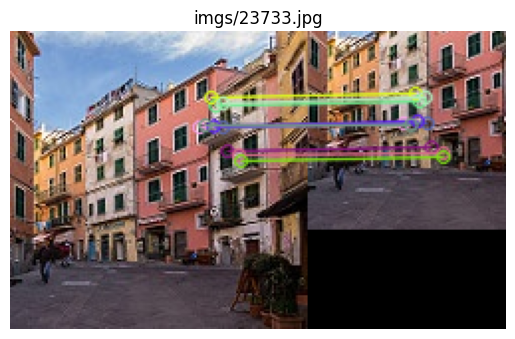

380it [00:00, 1330.61it/s]
70it [00:00, 1454.38it/s]


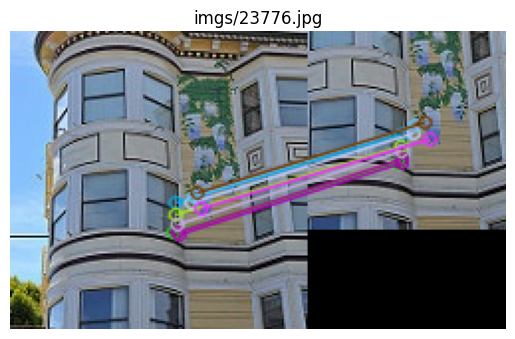

321it [00:00, 1106.83it/s]
111it [00:00, 1376.21it/s]


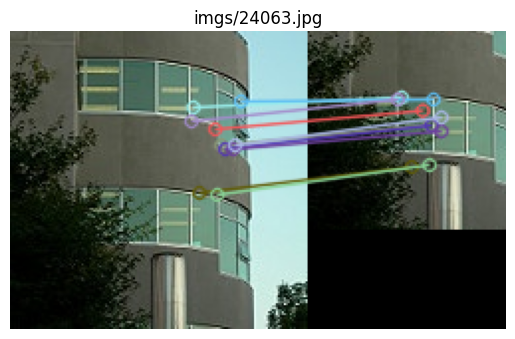

758it [00:00, 1415.99it/s]
122it [00:00, 1444.16it/s]


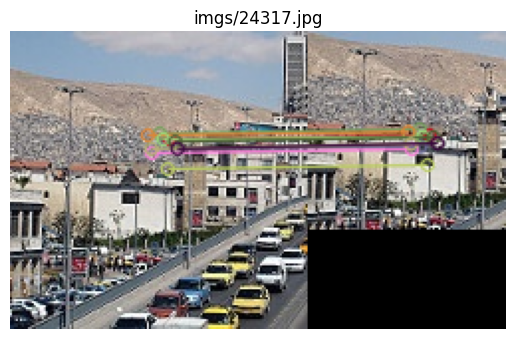

0it [00:00, ?it/s]/home/danylo/PycharmProjects/cv-2023/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/danylo/PycharmProjects/cv-2023/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
2000it [00:01, 1193.95it/s]
2000it [00:01, 1326.05it/s]


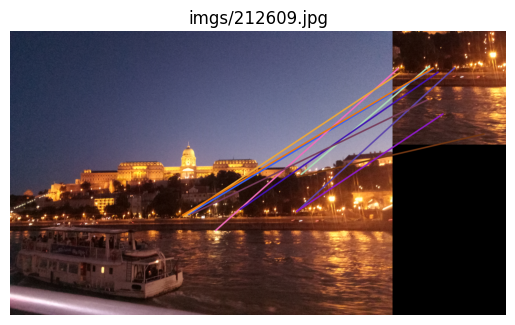

2000it [00:01, 1304.12it/s]
2000it [00:01, 1362.79it/s]


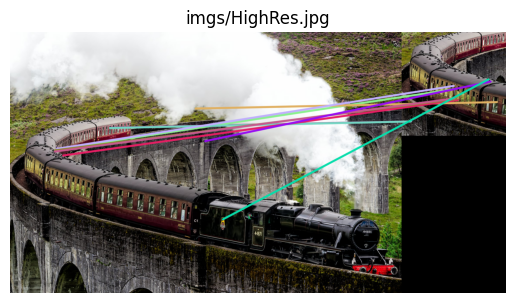

2000it [00:01, 1159.61it/s]
167it [00:00, 1081.33it/s]


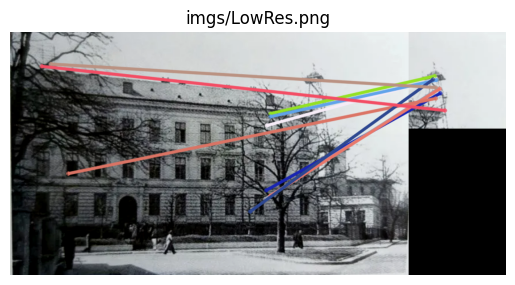

2000it [00:01, 1291.97it/s]
2000it [00:01, 1189.37it/s]


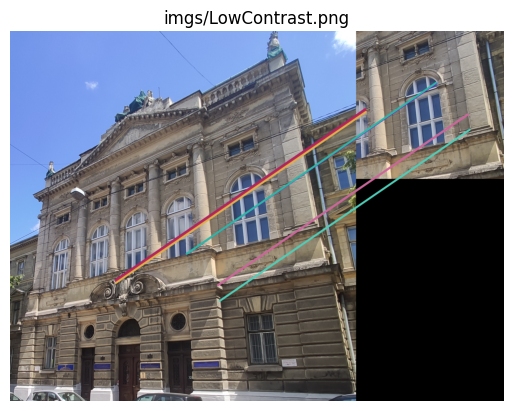

In [12]:
for img, img_, path in zip(imgs, imgs_, paths):
    show_imgs(ldb_match(img, img_, own_matcher=False), path)

747it [00:00, 1227.65it/s]
123it [00:00, 1365.64it/s]


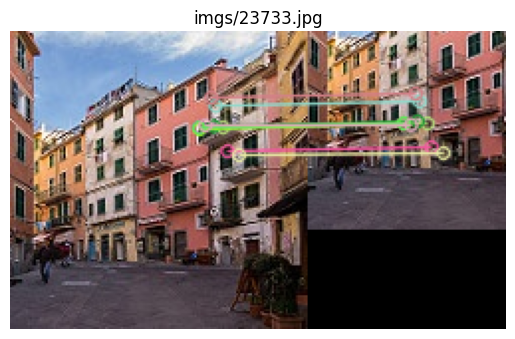

380it [00:00, 1265.72it/s]
70it [00:00, 1316.29it/s]


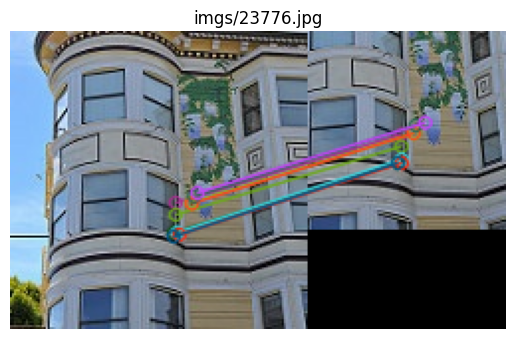

321it [00:00, 1298.56it/s]
111it [00:00, 1301.77it/s]


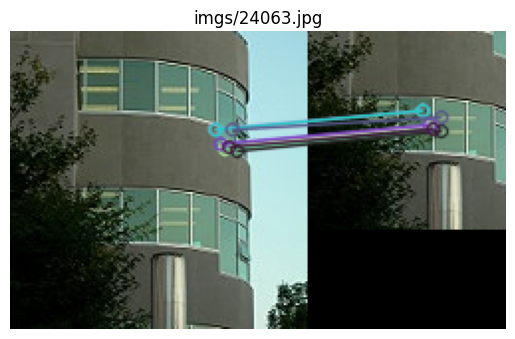

758it [00:00, 1374.14it/s]
122it [00:00, 1384.91it/s]


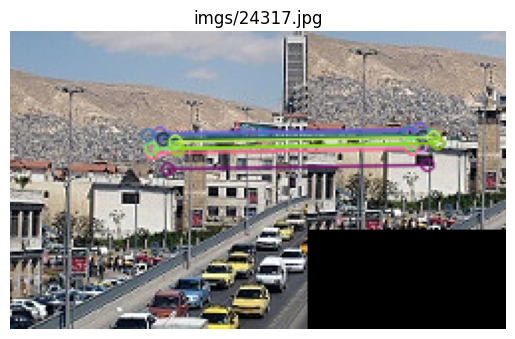

2000it [00:01, 1315.04it/s]
2000it [00:01, 1277.58it/s]


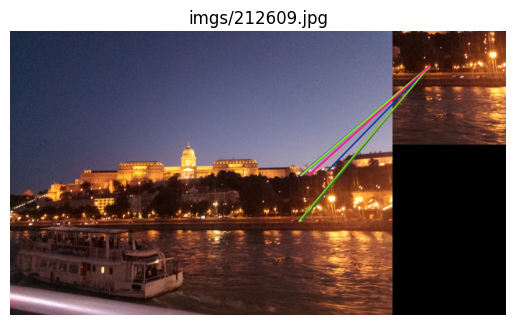

2000it [00:01, 1333.78it/s]
2000it [00:01, 1435.17it/s]


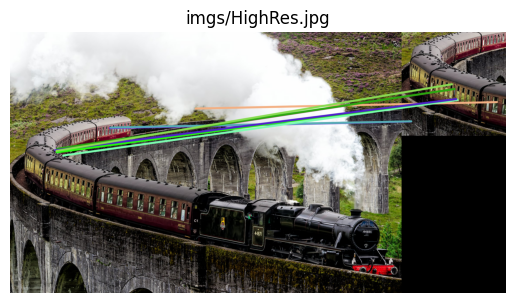

2000it [00:01, 1287.64it/s]
167it [00:00, 1390.42it/s]


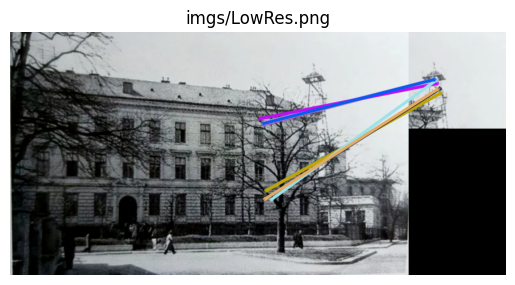

2000it [00:01, 1367.58it/s]
2000it [00:01, 1387.43it/s]


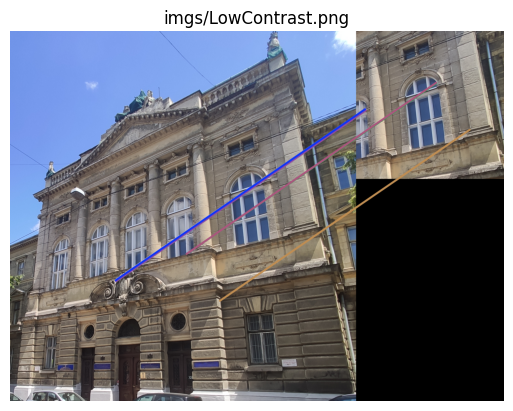

In [13]:
for img, img_, path in zip(imgs, imgs_, paths):
    show_imgs(ldb_match(img, img_, own_matcher=True), path)